In [1]:
import cProfile

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import time
from features import extract_features, calc_hog_features, calc_bin_spatial_features
from skimage.util.shape import view_as_windows
%matplotlib inline

In [3]:
dist_pickle = pickle.load( open('Car_NoCar_LinearSVC_1.p', 'r' ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orientations"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
color_scale = dist_pickle["color_scale"]
h_colorspace = dist_pickle["h_colorspace"]
s_colorspace = dist_pickle["s_colorspace"]
hog_channel = dist_pickle["hog_channel"]

In [4]:
X_scaler.mean_.shape

(6060L,)

In [47]:
#we will be using the same indexing of windows for all images. The data changes, but our indices will not
#Pre make this list. Consumes memory, but saves time
def get_hog_features_array_(img_shape, hog_data, patch_size=64, orient=9, channels=3,
                      pix_per_cell=8, cell_per_block=2, cells_per_step=4):
    cells_per_window = patch_size // pix_per_cell
    
    blocks_per_window = (cells_per_window - cell_per_block) + 1
    nxcells = img_shape[1] // pix_per_cell
    nycells = img_shape[0] // pix_per_cell
    
    nxblocks = (nxcells - cell_per_block) + 1 ##(W-F)/S + 1, W=ncells, F=cell_per_block, S=Stride=1
    nyblocks = (nycells - cell_per_block) + 1 ##(W-F)/S + 1, W=ncells, F=cell_per_block, S=Stride=1
    
    window_shape = (channels, blocks_per_window, blocks_per_window, cell_per_block, cell_per_block, orient)
    step = (1, cells_per_step, cells_per_step, 1, 1, 1)
    feature_vector_len = (channels * (blocks_per_window**2) * (cell_per_block**2) * orient)
    hog_windows = view_as_windows(hog_data, window_shape, step)
    hog_feature_array = hog_windows.reshape(-1, feature_vector_len)
    #print("Hog feature array shape: ", hog_feature_array.shape)
    return hog_feature_array

#Input is an image scaled by 0.5
def get_color_spatial_features_array_(color_data, patch_size, channels=3, pixels_per_step=16):
    #1 cell = 8 pixels for full scale image. Here we use 0.5 scale.
    window_shape = (patch_size, patch_size, channels)
    feature_vector_len = ((patch_size**2) * channels)
    step = (pixels_per_step, pixels_per_step, 1)
    color_spatial_windows = view_as_windows(color_data, window_shape, step)
    color_spatial_feature_array = color_spatial_windows.reshape(-1, feature_vector_len)
    return color_spatial_feature_array    

def get_feature_array(img_roi, hog_channel, h_cspace, s_cspace, c_scale=4, patch_size=64, orient=9,
                      pix_per_cell=8, cell_per_block=2, cells_per_step=4):
    
    hog_data = calc_hog_features(img_roi, orient, pix_per_cell, cell_per_block, 
                                 channel=hog_channel, cspace=h_cspace, vis=False, feature_vec=False)
    if hog_channel=='ALL':
        hog_channel=3;
    hog_feature_array = get_hog_features_array_(img_roi.shape, hog_data, patch_size, orient, hog_channel, 
                                          pix_per_cell, cell_per_block, cells_per_step)
    
    pixels_per_step = pix_per_cell*cells_per_step/c_scale
    color_data = calc_bin_spatial_features(img_roi, cspace=s_cspace, scale=c_scale, feature_vec=False)
    color_spatial_feature_array = get_color_spatial_features_array_(color_data, patch_size=patch_size/c_scale,
                                                              channels=3, pixels_per_step=pixels_per_step)
    #feature_array = np.array(hog_feature_array)
    feature_array = np.hstack((hog_feature_array, color_spatial_feature_array))
    print("Entire feature array ", feature_array.shape)
    return feature_array

def get_image_windows(img, img_scale, ystart, ystop, window, pix_per_step): 
    nxsteps = (img.shape[1]//img_scale - window)//pix_per_step + 1;
    nysteps = ((ystop - ystart)//img_scale - window)//pix_per_step + 1;
    print('Windows ', nxsteps, nysteps)
    x_list = np.arange(0, nxsteps)*pix_per_step*img_scale
    y_list = np.arange(0, nysteps)*pix_per_step*img_scale
    x_list = x_list.astype(int)
    y_list = y_list.astype(int)
    y_list = y_list + ystart
    draw_window_size = int(window*img_scale)
    return y_list, x_list, draw_window_size

In [48]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
              cells_per_step, color_scale=color_scale, hog_channel='ALL', show_windows=True):
    draw_img = np.copy(img)
    
    img_roi = img[ystart:ystop,:,:]
    
    if scale != 1:
        imshape = img_roi.shape
        img_roi = cv2.resize(img_roi, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    #y_start_list, x_start_list = get_image_windows(img, ystart, ystop, 64, cells_per_step*pix_per_cell*scale)
    x_size = img_roi.shape[1]
    y_size = img_roi.shape[0]
    feature_array = get_feature_array(img_roi, hog_channel, h_cspace=h_colorspace, s_cspace=s_colorspace, c_scale=color_scale,
          patch_size=64,orient=orient,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, cells_per_step=cells_per_step)
    
    trans_fa = X_scaler.transform(feature_array)
    p = svc.predict(trans_fa)
    
    #print(fa.shape)
    # Define blocks and steps as above
    #Number of Cells
    nxcells = x_size // pix_per_cell
    nycells = y_size // pix_per_cell
    #print(nxcells, nycells)
    #Number of Blocks
    nxblocks = (nxcells - cell_per_block) + 1 ##(W-F)/S + 1, W=ncells, F=cell_per_block, S=Stride=1
    nyblocks = (nycells - cell_per_block) + 1 
    #print(nxblocks, nyblocks)
    #nxblocks = (x_size // pix_per_cell)-1  
    #nyblocks = (y_size // pix_per_cell)-1 
    nfeat_per_block = orient * (cell_per_block**2)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = ((window // pix_per_cell) - cell_per_block) + 1
    #print(nblocks_per_window)
    #We have 8 cells per 64 pixels
    #Each cell step (8 pixels), refers to a move of 1/8 or overlap of 7/8=87.5% overlap
    #A step of 2 cells, means we slide windows by 16 pixels, overlap of 75%.
    #cells_per_step = 2  # Instead of overlap, define how many cells to step
    #Number of steps we can take over HoG array
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    #print(nxsteps, nysteps)
    # Compute individual channel HOG features for the entire image
    hog_array = extract_features(img_roi, h_cspace=h_colorspace, s_cspace=s_colorspace, orient=orient, 
                           pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                           hog_channel=hog_channel, feature_vec=False, vis=False)
    #The hog_array we get has a shape 3XnyblocksXnxblocksXcell_per_blockXcell_per_blockXorientations
    preds = 0
    cnt = -1
    print("for loop total windows: ", nxsteps*nysteps)
    print("for loop windows", nxsteps, nysteps)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            cnt= cnt+1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog_array[:, ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            # Extract the image patch
            subimg = cv2.resize(img_roi[ytop:ytop+window, xleft:xleft+window, :], (64,64))
            
            # Get color features
            spatial_features = calc_bin_spatial_features(subimg, s_colorspace, scale=color_scale, feature_vec=True)
            #if cnt == 0:
                #print(hog_features[1000:1100])
                #print(spatial_features.shape)
                #print(spatial_features[0:10])
            #hist_features = color_hist(subimg, nbins=hist_bins)
            
            if show_windows:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                color = np.random.randint(0, 256, (3,))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart), 
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart),color,6) 
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((hog_features, spatial_features)).reshape(1, -1))
            #test_features = X_scaler.transform(hog_features.reshape(1,-1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                preds = preds+1;
                print("fro loop pred cnt ", cnt)
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #color = np.random.randint(0, 256, (3,))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw, ytop_draw+win_draw+ystart),(0,0,255),6) 
            
                
    print("From for loop preds ", preds)
             
    return p, draw_img
    #return fa, draw_img

In [49]:
img = cv2.imread('test_images/test1.jpg') 
print(img.shape)
print(img.dtype)
#img = img[:, 900:1200, :]

(720L, 1280L, 3L)
uint8


In [50]:
def find_cars_scale(img, image_scale, ystart, yend, cells_per_step, show_windows):
    fa, out_img = find_cars(img, ystart, yend, image_scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                            cells_per_step=cells_per_step, color_scale=color_scale, hog_channel=hog_channel,
                            show_windows=show_windows)
    print("Time taken", time.time()-t1)
    plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
    plt.show()
    return fa

In [51]:
#cProfile.run('find_cars_1(img)')

In [52]:
imgwin_x.astype(int)

array([   0,   57,  115,  172,  230,  288,  345,  403,  460,  518,  576,
        633,  691,  748,  806,  864,  921,  979, 1036, 1094, 1152])

('Windows ', 26L, 3)
('Entire feature array ', (78L, 6060L))
('for loop total windows: ', 78L)
('for loop windows', 26L, 3L)
('fro loop pred cnt ', 55)
('fro loop pred cnt ', 77)
('From for loop preds ', 2)
('Time taken', 0.6740000247955322)


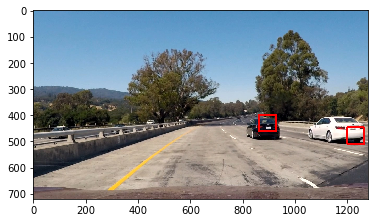

('time taken', 1.0150001049041748)


In [53]:
cells_per_step = 6
window = 64
ystart = 350
yend = ystart + window*3
image_scale = 1
imgwin_y, imgwin_x, draw_win_size = get_image_windows(img, image_scale, ystart, yend, 64, pix_per_cell*cells_per_step)
t1 = time.time()
p = find_cars_scale(img, image_scale, ystart, yend, cells_per_step, False)
print("time taken", time.time()-t1)

(0L,)
[]
[   0   48   96  144  192  240  288  336  384  432  480  528  576  624  672
  720  768  816  864  912  960 1008 1056 1104 1152 1200]
[350 398 446]
(26L, 3L)


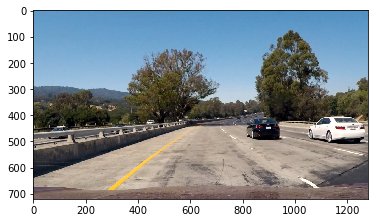

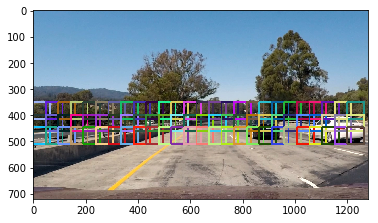

In [54]:
nz = p.nonzero()[0]
print(nz.shape)
print(nz)
print(imgwin_x)
print(imgwin_y)

num_cols = imgwin_x.shape[0]
num_rows = imgwin_y.shape[0]
print(num_cols, num_rows)
draw_img=np.copy(img)
for pred in nz:
    y_idx = pred // num_cols
    x_idx = pred - (y_idx*num_cols)
    xbox_left = imgwin_x[x_idx]
    ytop_draw = imgwin_y[y_idx]
    print(xbox_left, ytop_draw)
    #color = np.random.randint(0, 256, (3,))
    draw_img = cv2.rectangle(draw_img,(xbox_left, ytop_draw),
                  (xbox_left + draw_win_size, ytop_draw + draw_win_size),(0,0,255),6) 
    
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.show()

draw_img=np.copy(img)
for xleft in imgwin_x:
    for ytop in imgwin_y:
        xbox_left = xleft
        ytop_draw = ytop
        color = np.random.randint(0, 256, (3,))
        draw_img = cv2.rectangle(draw_img,(xbox_left, ytop_draw),
                                 (xbox_left+draw_win_size, ytop_draw+draw_win_size),color,6) 
    
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))

('Windows ', 21.0, 2.0)
('Entire feature array ', (42L, 6060L))
('for loop total windows: ', 42L)
('for loop windows', 21L, 2L)
('From for loop preds ', 0)
('Time taken', 0.2669999599456787)


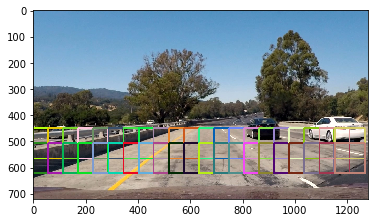

('time taken', 0.6419999599456787)


In [55]:
cells_per_step = 4
window = 64
ystart = 450
yend = ystart + window*3
image_scale = 1.8
imgwin_y, imgwin_x, draw_win_size = get_image_windows(img, image_scale, ystart, yend, 64, pix_per_cell*cells_per_step)
t1 = time.time()
p2 = find_cars_scale(img, image_scale, ystart, yend, cells_per_step, True)
print("time taken", time.time()-t1)

(0L,)
[]
[   0   57  115  172  230  288  345  403  460  518  576  633  691  748  806
  864  921  979 1036 1094 1152]
[450 507]
(21L, 2L)


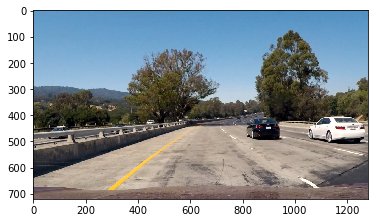

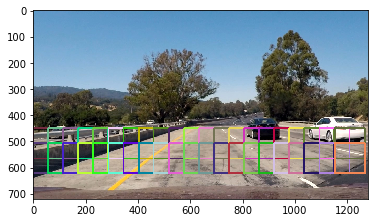

In [56]:
nz = p.nonzero()[0]
print(nz.shape)
print(nz)
print(imgwin_x)
print(imgwin_y)

num_cols = imgwin_x.shape[0]
num_rows = imgwin_y.shape[0]
print(num_cols, num_rows)
draw_img=np.copy(img)
for pred in nz:
    y_idx = pred // num_cols
    x_idx = pred - (y_idx*num_cols)
    xbox_left = imgwin_x[x_idx]
    ytop_draw = imgwin_y[y_idx]
    print(xbox_left, ytop_draw)
    #color = np.random.randint(0, 256, (3,))
    draw_img = cv2.rectangle(draw_img,(xbox_left, ytop_draw),
                  (xbox_left + draw_win_size, ytop_draw + draw_win_size),(0,0,255),6) 
    
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))
plt.show()
draw_img=np.copy(img)
for xleft in imgwin_x:
    for ytop in imgwin_y:
        xbox_left = xleft
        ytop_draw = ytop
        color = np.random.randint(0, 256, (3,))
        draw_img = cv2.rectangle(draw_img,(xbox_left, ytop_draw),
                                 (xbox_left+draw_win_size, ytop_draw+draw_win_size),color,6) 
    
plt.imshow(cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))

In [ ]:
def combine(img1, img2):
    return (cv2.addWeighted(img1, 0.5, img2, 0.5, 0))

In [ ]:
cap = cv2.VideoCapture('project_video.mp4')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
recorder = cv2.VideoWriter('out.mp4', fourcc, 30, (1280, 720))
t1 = time.time()
cnt = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        cnt+=1;
        #print("cnt", cnt)
        if cnt == 300:
            break
        if cnt%10 == 0:
            print('Time taken ', time.time()-t1)
        f1 = find_cars_1(frame)
        f2 = find_cars_2(frame)
        #print(f1.shape)
        #print(f2.shape)
        img_boxes = combine(find_cars_1(frame), find_cars_2(frame))
        recorder.write(img_boxes)
    else:
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
print('Time taken ', time.time()-t1)
cap.release()
recorder.release()
cv2.destroyAllWindows()

In [ ]:
roi = img[0:5, 0:5]
roi[0:2, 0:2, :]

In [ ]:
print(roi.shape)
r = np.ravel(roi)
print(r)

In [ ]:
view_as_windows(roi, (2,2,3))